In [1]:
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()

X_original = np.array(data['data'])
Y_original = np.array(data['target'], dtype=int)

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X_original, Y_original):
    X_train, Y_train = X_original[train_index, :], Y_original[train_index]
    X_test, Y_test = X_original[test_index, :], Y_original[test_index]
    
X_train, Y_train = X_original, Y_original
X_test, Y_test = X_original, Y_original

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('std_scaler', StandardScaler())])
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)

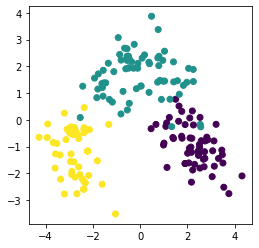

In [6]:
plt.figure(figsize=(4, 4))
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=Y_train)
plt.show()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(3)
knn.fit(X_train_scaled, Y_train)
Y_test_pred = knn.predict(X_test_scaled)
accuracy_score(Y_test, Y_test_pred)

0.9606741573033708

In [8]:
import loss
from mlnn import MLNN

config = 3
e_mode = 1

r = 1
s = 0
l = 1
inner = loss.SmoothReLU(.5)
outer = loss.SmoothReLU(.5)

alpha_0 = 1e-3
armijo = 1e-6
max_backtracks = 50

min_delta_F = 1e-6
max_steps = 100
max_time = 1

X = X_train_scaled
Y = Y_train
T = np.where(np.equal(Y.reshape(-1, 1), Y.reshape(1, -1)), 1, -1)
N = np.sum(T == 1, axis=1) - 1

sigma2 = 10 ** 1.12
P = X @ X.T
D = P.diagonal().reshape(-1, 1) + P.diagonal().reshape(1, -1) - 2 * P
G = np.exp(D / (-2 * sigma2))

n, d = X.shape

if config == 1:
    a_mode = 'WX'
    A = np.zeros((d, d))
    B = X
elif config == 2:
    a_mode = 'MX'
    A = np.zeros((n, n))
    B = X
elif config == 3:
    a_mode = 'MXX'
    A = np.zeros((n, n))
    B = P
elif config == 4:
    a_mode = 'MG'
    A = np.zeros((n, n))
    B = P
elif config == 5:
    a_mode = 'MXX'
    A = np.zeros((n, n))
    B = G
elif config == 6:
    a_mode = 'MG'
    A = np.zeros((n, n))
    B = G
    
if e_mode == 1:
    E = np.zeros(1)
elif e_mode == 2:
    E = np.zeros(n)
    
mlnn_params = {
    'r' : r,
    's' : s,
    'l' : l,
    'inner' : inner,
    'outer' : outer,
    'a_mode' : a_mode,
}

line_search_params = {
    'alpha_0' : alpha_0,
    'armijo' : armijo,
    'max_backtracks' : max_backtracks,
}

optimize_params = {
    'min_delta_F': min_delta_F,
    'max_steps' : max_steps,
    'max_time' : max_time,
}

mlnn = MLNN(B, T, N, A, E, mlnn_params, line_search_params, optimize_params)
mlnn.optimize(verbose=True)
mlnn.minimize(verbose=True)

step args bktr   alpha       phi      delta_F       F          R          S          L        mean_E  
   0  -    -       -          -          -       5.283e+03  0.000e+00  0.000e+00  5.283e+03  0.000e+00
   1  AE     8  6.938e-07 -8.455e+10  3.395e+03  1.888e+03  2.033e-02  0.000e+00  1.888e+03 -6.960e-03
   2  AE     3  2.371e-06 -1.535e+09  1.616e+03  2.719e+02  1.477e-02  0.000e+00  2.719e+02  5.165e-03
   3  AE     2  1.867e-05 -4.873e+07  1.331e+02  1.388e+02  1.454e-02  0.000e+00  1.388e+02  1.142e-02
   4  AE     1  5.013e-06 -1.745e+08  6.127e+01  7.755e+01  1.686e-02  0.000e+00  7.753e+01  1.005e-02
   5  AE     2  7.993e-06 -2.276e+07  6.013e+01  1.742e+01  1.595e-02  0.000e+00  1.740e+01  1.246e-02
   6  AE     1  1.040e-05 -3.102e+06  1.086e+01  6.560e+00  1.597e-02  0.000e+00  6.544e+00  1.285e-02
   7  AE     1  1.177e-05 -9.711e+05  5.278e+00  1.281e+00  1.580e-02  0.000e+00  1.265e+00  1.341e-02
   8  AE     0  1.982e-05 -5.768e+05  9.377e-01  3.434e-01  1.589e-02  0.